In [24]:
from utilities.setup_environment import *
from utilities.utilities import *
from utilities.plotting import *
from utilities.getStim import *
pd.set_option('display.max_columns', None)

import matplotlib.cm as cm
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
sns.set_context("poster")
from scipy.stats import sem
import os

In [25]:
cell_type = 'OFF sustained alpha' # ['OFF transient alpha' 'ON alpha' 'OFF sustained alpha']
cell_text = True # prints cellname next to the plot
frame_rate = 60


In [26]:
cell_type_str = re.sub(r'\W+', '_', cell_type.strip())
df_celltype = pd.read_csv(f'results/{cell_type_str}_PSD_gain.csv')
df_celltype = convert_stringified_arrays(df_celltype)

Converted the following columns to NumPy arrays:
  - freq
  - stim_psd
  - rs_spikes_psd
  - nr_spikes_psd
  - H_f_power_rs
  - H_f_power_nr
  - stim_autocorr
  - spikes_autocorr_rs
  - spikes_autocorr_nr


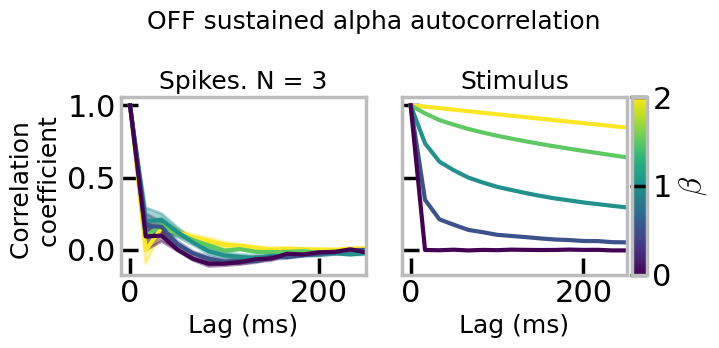

In [27]:

beta_values = sorted(df_celltype['beta'].unique())
norm = mcolors.Normalize(vmin=min(beta_values), vmax=max(beta_values))
cmap = plt.get_cmap('viridis')
label_fontsize = 18
fig, axes = plt.subplots(1,2 ,figsize=(8, 4), sharey=True)
fig.suptitle(f"{cell_type} autocorrelation", fontsize=18, y=.91)
n_cells = df_celltype['cell_name'].nunique()
# fig.text(0.45, 0.92, f"N = {n_cells}", ha='center', va='center', fontsize=18, transform=fig.transFigure)
for beta_value in reversed(beta_values):
    color = cmap(norm(beta_value))
    data_beta = df_celltype[df_celltype['beta'] == beta_value]
    stim_autocorr = df_celltype[df_celltype['beta'] == beta_value]['stim_autocorr'].iloc[0]
    spks_acc_stk = np.stack(data_beta['spikes_autocorr_nr'].values)
    # Compute mean & SEM 
    mean_spk_cc = np.mean(spks_acc_stk[:, :], axis=0)
    sem_spk_cc = np.std(spks_acc_stk[:, :], axis=0) / np.sqrt(n_cells)
    
    axes[1].plot(np.arange(len(stim_autocorr))*(1000/frame_rate), stim_autocorr, c=color, label=fr'$\beta = {beta_value}\ \mathrm{{Stim}} $')
    axes[1].set_title('Stimulus', fontsize=label_fontsize)
    axes[0].fill_between(np.arange(len(mean_spk_cc))*(1000/frame_rate), mean_spk_cc - sem_spk_cc, mean_spk_cc + sem_spk_cc, color=color, alpha=.4)
    axes[0].plot(np.arange(len(mean_spk_cc))*(1000/frame_rate), mean_spk_cc, c=color, label=fr"$\beta = {beta_value}$")
    axes[0].set_title('Spikes. N = ' + str(n_cells), fontsize=label_fontsize)

    axes[0].set_ylabel('Correlation \n coefficient', fontsize=label_fontsize)
    for ax in axes:
        ax.set_facecolor('white')
        ax.grid(False)
        ax.set_xlabel('Lag (ms)', fontsize=label_fontsize)
        ax.set_yticks([0, .5, 1])
        ax.set_xlim(-10, 250)

# Colorbar for beta
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
divider = make_axes_locatable(axes[1])
cax = divider.append_axes("right", size="7%", pad=0.05)
cbar = plt.colorbar(sm, cax=cax)
cbar.set_label(r'$\beta$', fontsize=22)
plt.tight_layout()


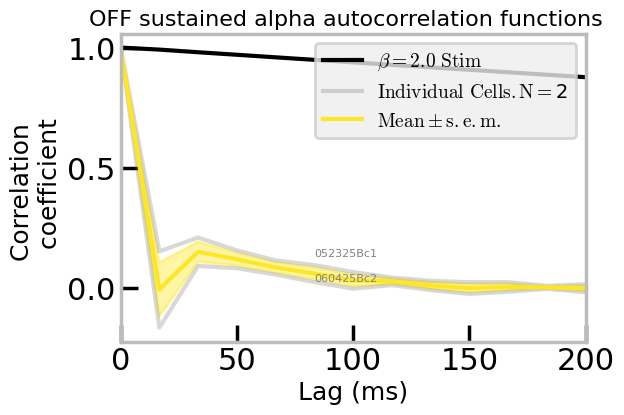

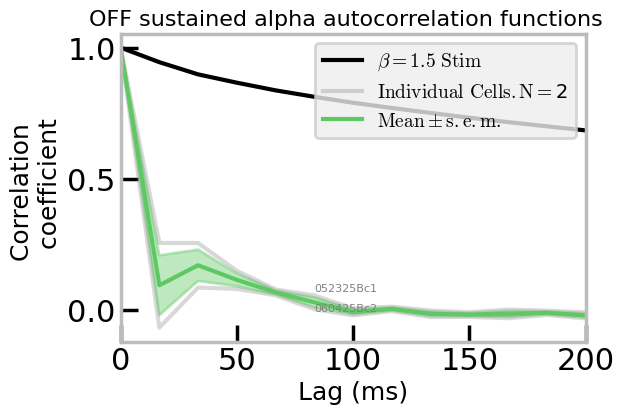

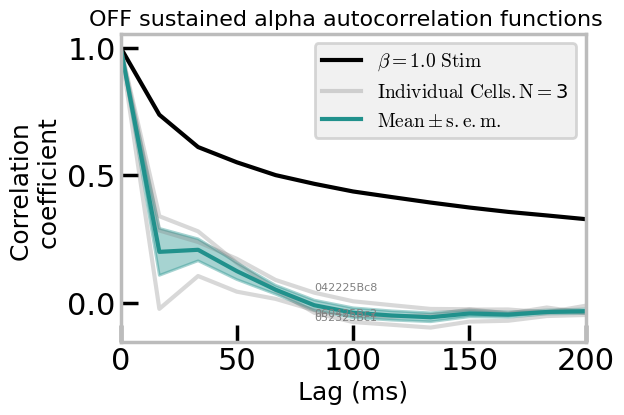

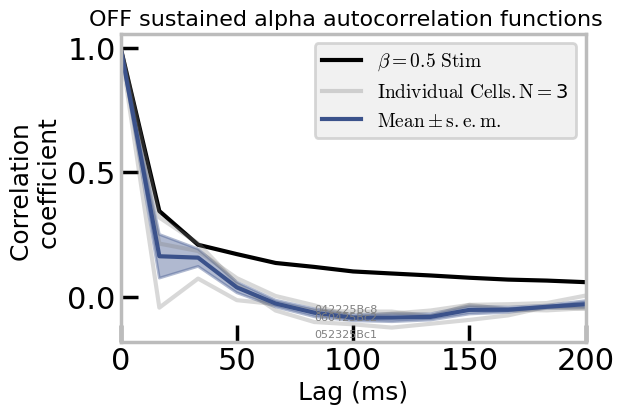

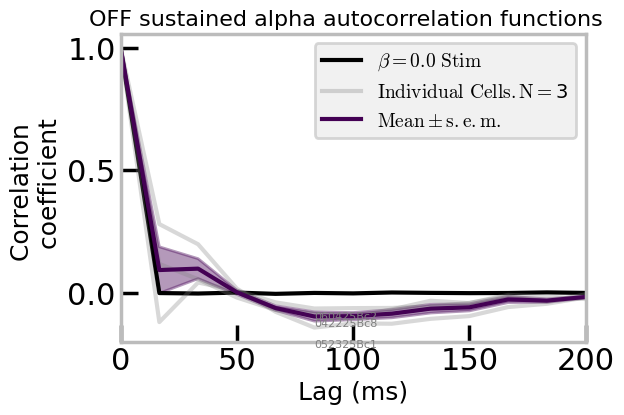

In [28]:

beta_values = sorted(df_celltype['beta'].unique())
norm = mcolors.Normalize(vmin=min(beta_values), vmax=max(beta_values))
cmap = plt.get_cmap('viridis')
label_fontsize = 18
for beta_value in reversed(beta_values):
    color = cmap(norm(beta_value))
    data_beta = df_celltype[df_celltype['beta'] == beta_value]
    n_cells = data_beta['cell_name'].nunique()
    stim_autocorr = df_celltype[df_celltype['beta'] == beta_value]['stim_autocorr'].iloc[0]
    spks_acc_stk = np.stack(data_beta['spikes_autocorr_nr'].values)
    # Compute mean & SEM 
    mean_spk_cc = np.mean(spks_acc_stk[:, :], axis=0)
    sem_spk_cc = np.std(spks_acc_stk[:, :], axis=0) / np.sqrt(n_cells)
    
    fig, axes = plt.subplots(figsize=(6, 4), sharey=False)
    fig.suptitle(f"{cell_type} autocorrelation functions", fontsize=16, y=.94)

    axes.plot(np.arange(len(stim_autocorr))*(1000/frame_rate), stim_autocorr, c='k', label=fr'$\beta = {beta_value}\ \mathrm{{Stim}} $')
    for i, cell_name in enumerate(data_beta['cell_name'].unique()):
        label_cell = r'$\mathrm{Individual \ Cells. N= } $' + str(n_cells) if i == 0 else None
        row = data_beta[data_beta['cell_name'] == cell_name].iloc[0]
        spikes_acc = row['spikes_autocorr_nr']
        time_axis = np.arange(len(spikes_acc)) * (1000 / frame_rate)

        
        axes.plot(time_axis, spikes_acc, c='gray', alpha=0.3, label=label_cell)
        if cell_text:
            x_pos = time_axis[5]
            y_pos = spikes_acc[5]
            axes.text(x_pos, y_pos*1.5, cell_name, fontsize=8, color='gray', ha='left', va='center')
    
    axes.fill_between(np.arange(len(mean_spk_cc))*(1000/frame_rate), mean_spk_cc - sem_spk_cc, mean_spk_cc + sem_spk_cc, color=color, alpha=.4)
    axes.plot(np.arange(len(mean_spk_cc))*(1000/frame_rate), mean_spk_cc, c=color, label=fr"$\mathrm{{Mean}} \pm \mathrm{{s.e.m.}}$")
    

    axes.set_facecolor('white')
    axes.legend(loc= 'upper right', fontsize=14)
    axes.set_ylabel('Correlation \n coefficient', fontsize=label_fontsize)
    axes.grid(False)
    axes.set_xlabel('Lag (ms)', fontsize=label_fontsize)
    axes.set_yticks([0, .5, 1])
    axes.set_xlim(0, 200)
